<a href="https://colab.research.google.com/github/sunandhini96/ERA_S6/blob/main/ERA_Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing the necessary packages

In [1]:
from __future__ import print_function #"print_function" is a statement in Python that is used to specify that the version of the print function being used should be the one defined in Python 3.x, rather than the one that is used in Python 2.x. 
import torch #Torch is a open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language. It provides a wide range of algorithms for deep learning and is used primarily for computer vision and natural language processing tasks.
import torch.nn as nn # torch.nn is a module within the PyTorch library that provides a set of classes and functions for building and training neural networks. It is a high-level API for building and training neural networks, and it is built on top of the lower-level torch.nn.functional module.
#The main feature of torch.nn is the nn.Module class, which provides a convenient way to define and organize the layers of a neural network. The nn.Module class is the base class for all neural network modules in PyTorch, and it provides a number of useful methods and attributes for building and training neural networks.
import torch.nn.functional as F
import torch.optim as optim  #torch.optim is a module within the PyTorch library that provides a set of optimization algorithms for updating the parameters of neural networks. It is used to optimize the weights and biases of the neural network in order to minimize the loss function.
from torchvision import datasets, transforms #importing datasets from torchvision
!pip install torchsummary
import torchvision # provide access to datasets, models, transforms, utils, etc
from torchsummary import summary
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load the data


In [2]:
use_cuda = torch.cuda.is_available()

In [3]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [4]:
batch = next(iter(train_loader))

len(batch), type(batch)

(2, list)

In [5]:
images, labels = batch

In [6]:
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Plotting :

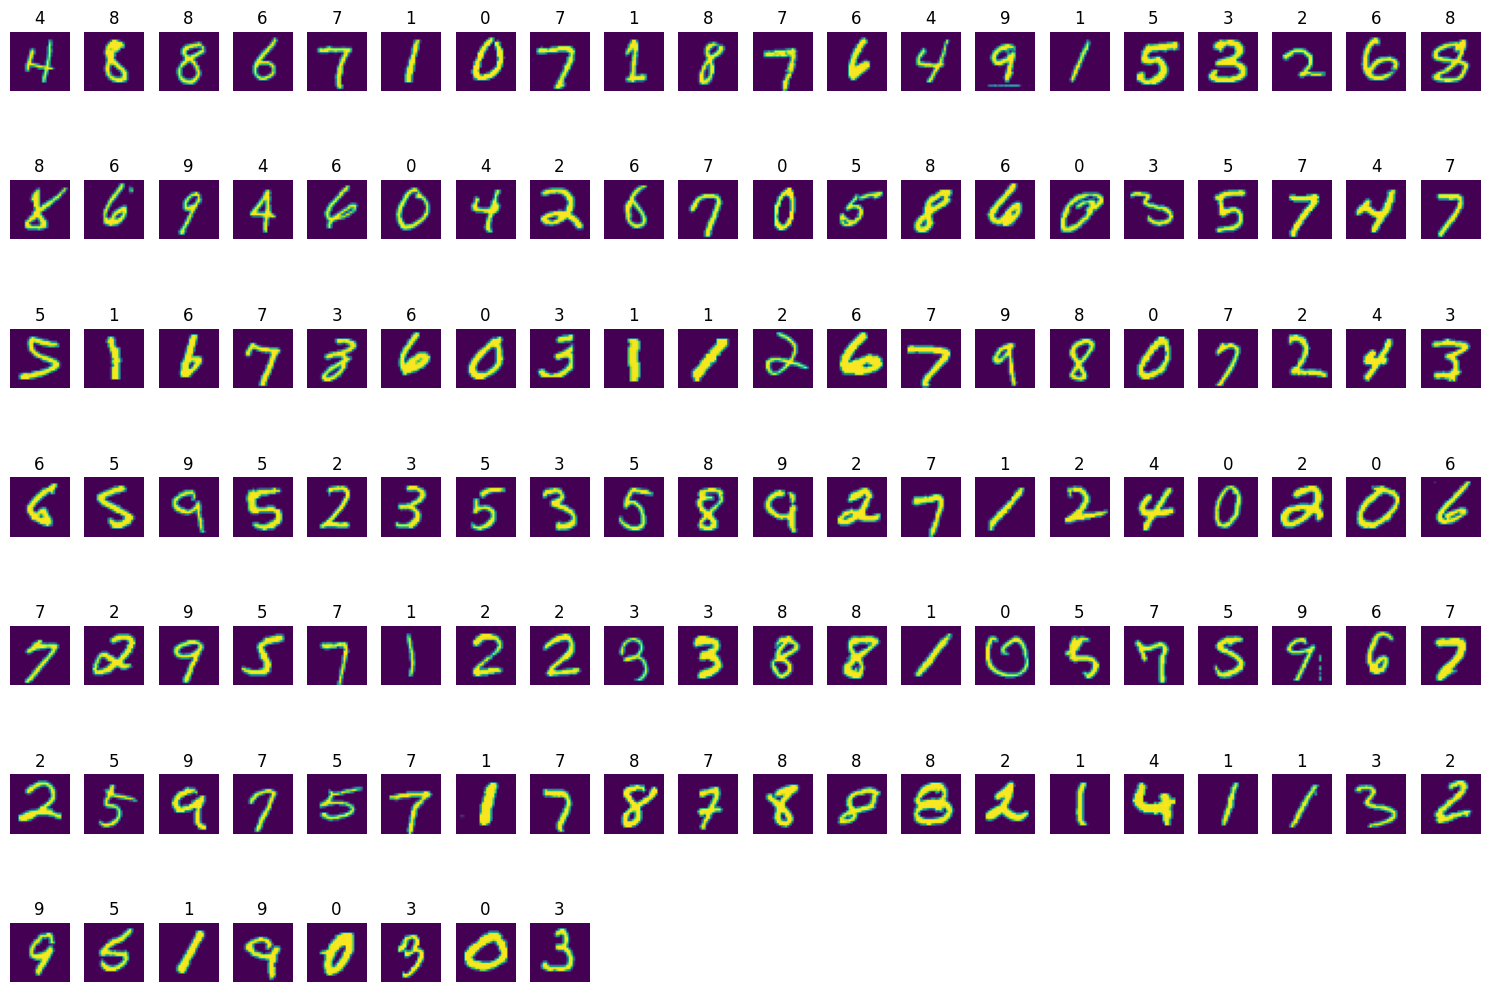

In [7]:
import torchvision
import matplotlib.pyplot as plt

# Create a figure and axes for subplots
fig, axes = plt.subplots(figsize=(15, 15), nrows=10, ncols=20)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over images and labels
for i, (image, label) in enumerate(zip(images, labels)):
    #print(image.shape)
    # Convert image tensor to numpy array and transpose dimensions
    image_np = image.numpy().transpose(1, 2, 0)
    #print(image_np.shape)
    # Display the image
    axes[i].imshow(image_np)
    
    # Set the title as the corresponding label
    axes[i].set_title(label.item())
    
    # Remove ticks and labels from the axes
    axes[i].axis('off')

# Remove extra subplots if present
if len(images) < len(axes):
    for j in range(len(images), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()



# Network

In [10]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # output_size = 26 | RF 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.05)
        ) # output_size = 24 | RF 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24 | RF 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 | RF 7

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # output_size = 10 | RF 11
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(0.05)
        ) # output_size = 8 | RF 15
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(0.05)
        ) # output_size = 6 | RF 19
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            #nn.Dropout(0.05)
        ) # output_size = 6 | RF 23
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1 | RF 43

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) #RF 43


        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
     


## Summary of the model

In [11]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

## Training and testing loops:

In [12]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))


## Training the network

In [13]:

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


loss=0.07790514081716537 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 0.0763, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


loss=0.09397108107805252 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]



Test set: Average loss: 0.0633, Accuracy: 9808/10000 (98.08%)

EPOCH: 2


loss=0.018836800009012222 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]



Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)

EPOCH: 3


loss=0.08602729439735413 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


loss=0.006202130112797022 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.0243, Accuracy: 9931/10000 (99.31%)

EPOCH: 5


loss=0.02641492523252964 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]



Test set: Average loss: 0.0270, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


loss=0.02400313876569271 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]



Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


loss=0.02343975193798542 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]



Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

EPOCH: 8


loss=0.029719745740294456 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]



Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


loss=0.03981277346611023 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0207, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


loss=0.004856004845350981 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0203, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


loss=0.032489705830812454 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]



Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


loss=0.05288465693593025 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]



Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


loss=0.0554722435772419 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.94it/s]



Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


loss=0.0320533886551857 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

